# Induced Seismicity

**Fill me in!**

In [34]:
from scipy.stats.stats import pearsonr

def largest_corr(rank1, rank2,lag=12):
    r1 = rank1[:-12]
    corrs = list(map(lambda i: pearsonr(r1, rank2[i:(len(r1)+i)]), range(lag+1)))
    return np.amax(corrs)

def simulate(ranks1, ranks2, num_trials=10000):
    """
    Given two rank vectors, repeatedly permutes ranks and gets 
    the largest normalized dot product. Return all simulated values.
    Like `dot_normalized()`, this assumes we are shifting `rank2`
    forward.
    """
    # Used to simulate a single trial. The input is not used
    def simulate_single_trial(_):
        np.random.shuffle(ranks1)
        # shuffle rank2
        np.random.shuffle(ranks2)
        return largest_corr(ranks1, ranks2)
    
    # Make a copy for ranks1 because np.random.shuffle is in place
    ranks1 = ranks1.copy()

    return np.array(list(map(simulate_single_trial, range(num_trials))))

def p_value(dist, observed):
    """
    Given an empirical distribution `dist`, this function returns the
    probability of seeing `observed` or larger (i.e. this is one-sided).
    The empirical `dist`, for instance, would look like the return of
    the `simulate` function above.
    """
    return np.sum(dist >= observed) / float(len(dist))

In [35]:
%%time

a = np.arange(1, 457)
b = np.arange(1, 457)
og_b = b.copy()
allsim = simulate(a, b)

CPU times: user 9.08 s, sys: 97.4 ms, total: 9.18 s
Wall time: 9.19 s


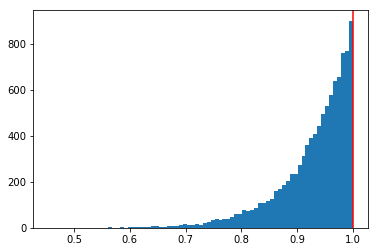

In [36]:
import matplotlib.pyplot as plt

og = largest_corr(a, og_b)
plt.hist(allsim, bins = 'auto')
plt.axvline(x = og, color = 'red')
plt.show()

In [24]:
def get_eq(water):
    eq = np.array([np.random.poisson(np.exp(np.random.randn(1))*(0.0001+0.0005*water[i])) 
                   for i in range(len(water))])

    return eq

from scipy.stats import rankdata

0.4544


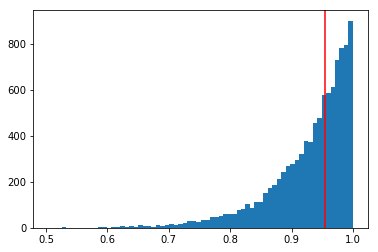

CPU times: user 9.25 s, sys: 158 ms, total: 9.41 s
Wall time: 9.62 s


In [37]:
%%time
t=np.arange(450)
water1 = 1000-0.003*(t-200)**2+20*np.random.randn(450)
#water2 = np.append(1000-5*np.arange(40)+50*np.random.randn(40), np.zeros(60))
eq1=get_eq(water1)

eq_ranks = rankdata(eq1)
water_ranks = rankdata(water1)
s = simulate(eq_ranks, water_ranks)
og = largest_corr(eq_ranks, water_ranks)
print(p_value(s, og))
plt.hist(s, bins = 'auto')
plt.axvline(x = og, color = 'red')
plt.show()

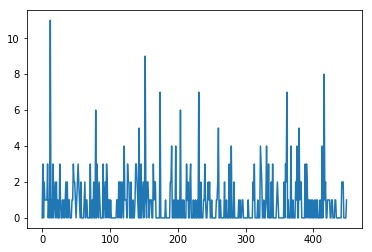

In [39]:
plt.plot(eq1)
plt.show()

In [62]:
# real water data
import pandas as pd
df=pd.read_table('~/Downloads/water_ex.txt', sep=' ')
water = df['xxxx'].tolist()

In [84]:
def get_eq(water):
    eq = np.array([np.random.poisson(np.exp(np.random.randn(1))*(0.0000001+0.000005*water[i])) 
                   for i in range(len(water))])

    return eq

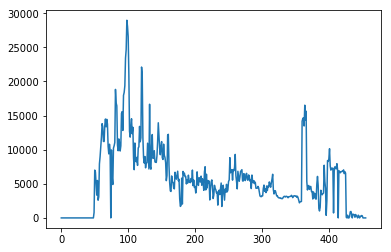

In [85]:
plt.plot(water)
plt.show()

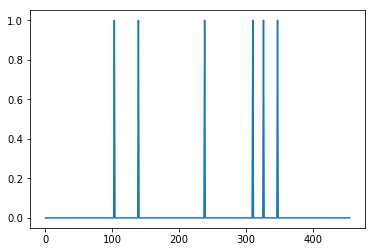

In [86]:
eq=get_eq(water)
plt.plot(eq)
plt.show()

0.4063


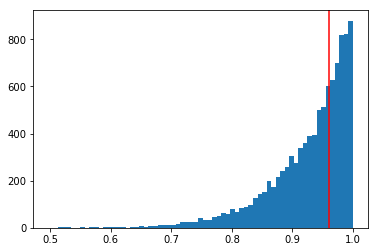

In [87]:
eq_ranks = rankdata(eq)
water_ranks = rankdata(water)
s = simulate(eq_ranks, water_ranks)
og = largest_corr(eq_ranks, water_ranks)
print(p_value(s, og))
plt.hist(s, bins = 'auto')
plt.axvline(x = og, color = 'red')
plt.show()

old

In [ ]:
# Put all scripts that should be loaded here
%load simulate.py

In [1]:
import numpy as np

def dot_normalized(ranks1, ranks2, lag=0, use_zeros=False):
    """
    Shifts `ranks2` forward by `lag` number of entries.
    Removes the tail ends of the rank vectors that fall off
    after shifting. Then returns the dot product normalized
    by the number of entries that were used in the dot.
    For instance, suppose
         ranks1  = [1, 2, 3, 4]
         ranks2  = [4, 3, 2, 1]
         lag     = 2.
    After shifting and removing the fall off, we have
         ranks1' = [3, 4]
         ranks2' = [4, 3]
    The normalized dot is (3 * 4 + 4 * 3) / 2.

    Assumes that len(ranks1) == len(ranks2) and all ranks
    are non-negative.

    Args:
        ranks1    (1D np.array) : Ranks for first dataset
        ranks2    (1D np.array) : Ranks for second dataset
        lag       (int)         : Number of entries to shift
        use_zeros (bool)        : Use zeros in rank vectors
                                  for normalizing
    Returns:
        Normalized dot product after shifting by `lag`
    """
    assert len(ranks1) == len(ranks2), \
           "Rank vectors are not the same length"

    # Count the number of entries that would be zeroed out
    # in either vector
    num_zeros = 0
    if not use_zeros:
        num_zeros = np.sum((ranks1 * ranks2) == 0)

    # Pad rank vectors with zeros (from front w/ ranks1, 
    # from back w/ ranks2); equivalent to shifting
    padded_ranks1 = np.append(ranks1, np.zeros(lag))
    padded_ranks2 = np.insert(ranks2, 0, np.zeros(lag))

    # Normalization constant
    num_valid = float(len(ranks1) - lag - num_zeros)

    return np.dot(padded_ranks1, padded_ranks2) / num_valid

def largest_dot_normalized(ranks1, ranks2, min_lag=0, max_lag=12, use_zeros=False):
    """
    Returns the largest normalized dot product of the two rank vectors
    across all possible lags specified by `min_lag` and `max_lag`. 
    Inclusive of both `min_lag` and `max_lag`.
    """
    # Used to get the dot normalized for provided arguments, varying lag
    def dot_normalized_call(lag):
        return dot_normalized(ranks1, ranks2, lag, use_zeros)

    dots = list(map(dot_normalized_call, range(min_lag, max_lag + 1)))
    return np.amax(dots)

def simulate(ranks1, ranks2, num_trials=10000, min_lag=0, max_lag=12, use_zeros=False):
    """
    Given two rank vectors, repeatedly permutes ranks and gets 
    the largest normalized dot product. Return all simulated values.
    Like `dot_normalized()`, this assumes we are shifting `rank2`
    forward.
    """
    # Used to simulate a single trial. The input is not used
    def simulate_single_trial(_):
        np.random.shuffle(ranks1)
        return largest_dot_normalized(ranks1, ranks2, min_lag, max_lag, use_zeros)
    
    # Make a copy for ranks1 because np.random.shuffle is in place
    ranks1 = ranks1.copy()

    return np.array(list(map(simulate_single_trial, range(num_trials))))

def p_value(dist, observed):
    """
    Given an empirical distribution `dist`, this function returns the
    probability of seeing `observed` or larger (i.e. this is one-sided).
    The empirical `dist`, for instance, would look like the return of
    the `simulate` function above.
    """
    return np.sum(dist >= observed) / float(len(dist))


In [8]:
%%time

a = np.arange(1, 457)
b = np.arange(1, 457)
np.random.shuffle(b)
og_b = b.copy()
allsim = simulate(a, b)

CPU times: user 4.91 s, sys: 42.6 ms, total: 4.95 s
Wall time: 5.02 s


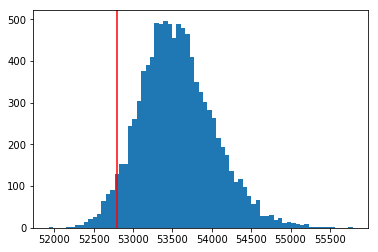

In [10]:
import matplotlib.pyplot as plt

og = largest_dot_normalized(a, b)
plt.hist(allsim, bins = 'auto')
plt.axvline(x = og, color = 'red')
plt.show()

In [21]:
np.dot(a, a) / 456.

69540.166666666672

In [24]:
np.dot(a, np.flip(a, axis=0)) / 456.

34884.333333333336

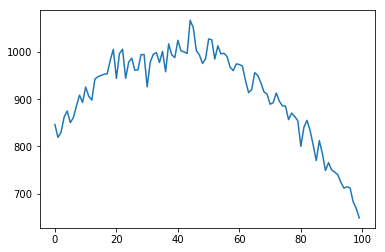

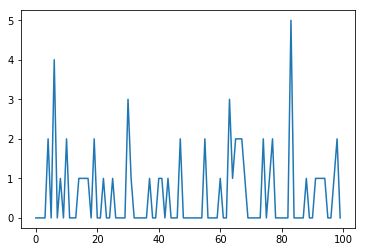

In [11]:
t=np.arange(100)

e1 = np.random.randn(100)

water1 = 1000-0.1*(t-40)**2+20*e1

plt.plot(water1)
plt.show()

def get_eq(water):
    eq = np.array([np.random.poisson(np.exp(np.random.randn(1))*(0.0001+0.0005*water[i])) 
                   for i in range(len(water))])
#     plt.plot(eq)
#     plt.show()
    return eq

eq1=get_eq(water1)
plt.plot(eq1)
plt.show()


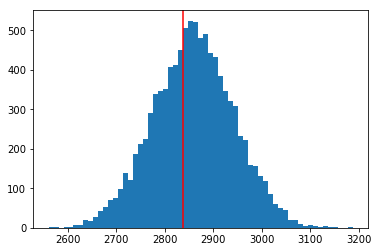

In [12]:
eq_ranks = rankdata(eq1)
water_ranks = rankdata(water1)
s = simulate(eq_ranks, water_ranks)
og = largest_dot_normalized(eq_ranks, water_ranks)
plt.hist(s, bins = 'auto')
plt.axvline(x = og, color = 'red')
plt.show()

0.0443


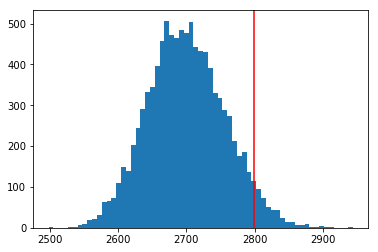

CPU times: user 4.6 s, sys: 20 ms, total: 4.62 s
Wall time: 4.62 s


In [21]:
%%time
t=np.arange(100)
# e1 = np.random.randn(100)
# water1 = 1000-0.03*(t-40)**2+20*e1
water2 = np.append(1000-5*np.arange(40)+50*np.random.randn(40), np.zeros(60))
eq1=get_eq(water2)

eq_ranks = rankdata(eq1)
water_ranks = rankdata(water2)
s = simulate(eq_ranks, water_ranks)
og = largest_dot_normalized(eq_ranks, water_ranks)
print(p_value(s, og))
plt.hist(s, bins = 'auto')
plt.axvline(x = og, color = 'red')
plt.show()

In [19]:
p_value(s, og)

0.0085000000000000006

In [4]:
%%time
a = np.arange(1, 451)
b = np.arange(1, 451)
avg = np.mean(a)
var = np.var(a)

def calc(x, y):
    cov = np.sum((x - avg) * (y - avg)) / len(x)
    return cov / var

def calc_all(x, y):
    all_lags = [calc(x, y)]
    all_lags.extend(list(map(lambda i: calc(x[:-i], y[i:]), range(1, 450))))
    return all_lags

lags = np.zeros(450)
for i in range(100000):
    np.random.shuffle(a)
    bleh = calc_all(a, b)
    lags[np.argmax(bleh)] += 1

CPU times: user 9min 28s, sys: 4.57 s, total: 9min 33s
Wall time: 9min 38s


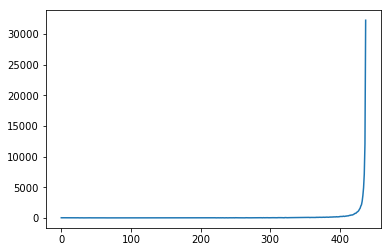

In [5]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

plt.plot(lags[12:])
plt.show()

In [2]:
import numpy as np
a=np.arange(20)

In [7]:
a[2:20]

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])